# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

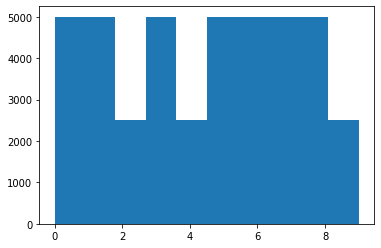

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Load AE models weight

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [11]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [12]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output) # 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 7
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128

    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 8
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 9
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x) # 11
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x) # 12

    return Model(input_img, y)

#### Train with data augumentation 1

In [17]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [18]:
# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_032_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10,
#         shear_range=0.2,
        horizontal_flip=True,
#         vertical_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
        zoom_range=0.1
#         channel_shift_range=0.2
        )
    
    #Mixup augumentation
    batch_size = 32
    train_datagenerator = MixupGenerator(x_train_, y_train_onehot, batch_size=batch_size, 
                                        alpha=0.2, datagen=train_datagen)()    
#     train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model_history = model.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model.load_weights(chkpt)
    scores = model.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model.predict(x_test)
    predicts += predict
    
    histories.append(model_history.history)
    fold_no += 1

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
883/885 [============================>.] - ETA: 0s - loss: 1.7231 - accuracy: 0.4147
Epoch 00001: val_loss improved from inf to 1.58918, saving model to ../models/CNN\Model_032_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.7223 - accuracy: 0.4150 - val_loss: 1.5892 - val_accuracy: 0.4797
Epoch 2/400
882/885 [============================>.] - ETA: 0s - loss: 1.4110 - accuracy: 0.5594
Epoch 00002: val_loss improved from 1.58918 to 1.08451, saving model to ../models/CNN\Model_032_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.4112 - accuracy: 0.5595 - val_loss: 1.0845 - val_accuracy: 0.6173
Epoch 3/400
884/885 [============================>.] - ETA: 0s - loss: 1.2210 - accuracy: 0.6391
Epoch 00003: val_loss did not improve from 1.08451
885/885 [==============================] - 10s 11ms/step - loss: 1.2210 - accuracy: 0.6391 - val_loss: 1

883/885 [============================>.] - ETA: 0s - loss: 0.8560 - accuracy: 0.7973
Epoch 00008: val_loss improved from 0.65915 to 0.62550, saving model to ../models/CNN\Model_032_2_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 0.8558 - accuracy: 0.7973 - val_loss: 0.6255 - val_accuracy: 0.7926
Epoch 9/400
884/885 [============================>.] - ETA: 0s - loss: 0.8223 - accuracy: 0.8101
Epoch 00009: val_loss improved from 0.62550 to 0.58816, saving model to ../models/CNN\Model_032_2_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 0.8224 - accuracy: 0.8101 - val_loss: 0.5882 - val_accuracy: 0.8042
Epoch 10/400
880/885 [============================>.] - ETA: 0s - loss: 0.8091 - accuracy: 0.8165
Epoch 00010: val_loss did not improve from 0.58816
885/885 [==============================] - 10s 11ms/step - loss: 0.8084 - accuracy: 0.8168 - val_loss: 0.6422 - val_accuracy: 0.7981
Epoch 11/400
881/885 [============================>.] 

Epoch 17/400
881/885 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.8794
Epoch 00017: val_loss did not improve from 0.44506
885/885 [==============================] - 10s 11ms/step - loss: 0.6511 - accuracy: 0.8795 - val_loss: 0.4593 - val_accuracy: 0.8548
Epoch 00017: early stopping
443/443 [==============================] - 2s 4ms/step - loss: 0.4449 - accuracy: 0.8544
Score for fold 3: loss of 0.4448539912700653; accuracy of 85.43696403503418%


In [19]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1000
           1       0.94      0.95      0.95      1000
           2       0.91      0.71      0.80      1000
           3       0.78      0.78      0.78      1000
           4       0.87      0.83      0.85      1000
           5       0.85      0.80      0.82      1000
           6       0.80      0.96      0.87      1000
           7       0.90      0.93      0.91      1000
           8       0.94      0.94      0.94      1000
           9       0.95      0.90      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [20]:
print(f'CV ACC is {cv_acc//n_splits},n_splits CV macro F1 is {cv_f1//n_splits}')

CV ACC is 84.0,n_splits CV macro F1 is 83.0


#### Train with data augumentation 2

In [23]:
# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_033_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10,
#         shear_range=0.2,
        horizontal_flip=True,
#         vertical_flip=True,
        width_shift_range=4.0/32, # 4 pix
        height_shift_range=4.0/32, # 4 pix
        zoom_range=0.1
#         channel_shift_range=0.2
        )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model_history = model.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model.load_weights(chkpt)
    scores = model.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model.predict(x_test)
    predicts += predict
    
    histories.append(model_history.history)
    fold_no += 1

Epoch 1/400
884/885 [============================>.] - ETA: 0s - loss: 1.6005 - accuracy: 0.4238
Epoch 00001: val_loss improved from inf to 1.67438, saving model to ../models/CNN\Model_033_1_Best.hdf5
885/885 [==============================] - 10s 12ms/step - loss: 1.6002 - accuracy: 0.4239 - val_loss: 1.6744 - val_accuracy: 0.4445
Epoch 2/400
885/885 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.5654
Epoch 00002: val_loss improved from 1.67438 to 1.46659, saving model to ../models/CNN\Model_033_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.2228 - accuracy: 0.5654 - val_loss: 1.4666 - val_accuracy: 0.5279
Epoch 3/400
885/885 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.6503
Epoch 00003: val_loss improved from 1.46659 to 1.02725, saving model to ../models/CNN\Model_033_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.0036 - accuracy: 0.6503 - val_loss: 1.0273 - val_accurac

Epoch 14/400
885/885 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8729
Epoch 00014: val_loss improved from 0.51759 to 0.48697, saving model to ../models/CNN\Model_033_2_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 0.3731 - accuracy: 0.8729 - val_loss: 0.4870 - val_accuracy: 0.8384
Epoch 15/400
885/885 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8812
Epoch 00015: val_loss did not improve from 0.48697
885/885 [==============================] - 10s 11ms/step - loss: 0.3478 - accuracy: 0.8812 - val_loss: 0.5677 - val_accuracy: 0.8170
Epoch 16/400
881/885 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8877
Epoch 00016: val_loss did not improve from 0.48697
885/885 [==============================] - 10s 11ms/step - loss: 0.3226 - accuracy: 0.8876 - val_loss: 0.5685 - val_accuracy: 0.8243
Epoch 17/400
883/885 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8914

In [24]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1000
           1       0.89      0.98      0.93      1000
           2       0.92      0.64      0.75      1000
           3       0.79      0.73      0.76      1000
           4       0.88      0.80      0.84      1000
           5       0.86      0.78      0.82      1000
           6       0.79      0.95      0.86      1000
           7       0.83      0.95      0.88      1000
           8       0.93      0.94      0.93      1000
           9       0.97      0.86      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



In [25]:
print(f'CV ACC is {cv_acc//n_splits},n_splits CV macro F1 is {cv_f1//n_splits}')

CV ACC is 83.0,n_splits CV macro F1 is 82.0
